# MNIST Reconstruction with Bernoulli Restricted Boltzmann Machines (RBM)

In [14]:
# credits to: https://github.com/patricieni/RBM-Tensorflow
import tensorflow as tf
import os 
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import time 

from rbm import RBM, sample

## TODO

## Initialize RBM

In [15]:
# MNIST dataset
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)
mnist_train = mnist.train

# Initialize RBM Model for MNIST reconstruction
rbm_model = RBM(n_visible = 784, n_hidden = 64, lr = tf.constant(0.1,tf.float32), epochs = 2000)

# Placeholder for the visible layer of the RBM computation graph.
v = tf.placeholder(tf.float32, shape=[None, rbm_model.n_visible], name="visible_layer")
size = tf.cast(tf.shape(v)[0], tf.float32) # batch size

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## K-step Contrastive Divergence using Gibbs sampling

In [16]:
# Positive divergence: + v_0^T * p(h_0|v_0)
with tf.name_scope('Hidden_probabilities'):
    pos_hid_prob = rbm_model.get_probabilities('hidden', v)
with tf.name_scope('Positive_Divergence'):
    pos_divergence = tf.matmul(tf.transpose(v),pos_hid_prob)

pos_hid_states = sample(pos_hid_prob)
neg_vis_prob = rbm_model.get_probabilities('visible', pos_hid_states)
#neg_vis_states = rbm.sample(neg_vis_prob)

# Negative divergence: - v_sampled^T * p(h_sample_k+1|v_sample_k)
with tf.name_scope('Negative_hidden_probabilities'):
    neg_hid_prob = rbm_model.get_probabilities('hidden', neg_vis_prob)
with tf.name_scope('Negative_Divergence'):
    neg_divergence = tf.matmul(tf.transpose(neg_vis_prob), neg_hid_prob)

## Update rule

In [17]:
# Update rules for weights and biases
with tf.name_scope('Weight_gradient'):
    delta_w = (rbm_model.lr/size)*(pos_divergence-neg_divergence)
    weight_gradient_scalar = tf.summary.scalar('weight_increment',tf.reduce_mean(delta_w)) # Debug mode: plot weight increment during training
with tf.name_scope('Visible_bias_gradient'):
    delta_vb = (rbm_model.lr/size)*(tf.reduce_sum(v-neg_vis_prob, 0, keep_dims=True))
with tf.name_scope('Hidden_bias_gradient'):
    delta_hb= (rbm_model.lr/size)*(tf.reduce_sum(pos_hid_prob-neg_hid_prob, 0, keep_dims=True))

update = [rbm_model.W.assign_add(delta_w), rbm_model.vb.assign_add(delta_vb), rbm_model.hb.assign_add(delta_hb)] 

## Train / Test metrics

In [18]:
# Similarity between reconstructed/sampled visible layer and input during training. 
rec_error = tf.reduce_mean(tf.squared_difference(v, neg_vis_prob))
tf.summary.scalar('reconstruction_error',rec_error)

# Free energy
energy = rbm_model.free_energy(v = v)

# Merge summaries for Tensorboard visualization
summary = tf.summary.merge_all()
# Save & restore all the variables.
saver = tf.train.Saver({"weights":rbm_model.W, "visible_bias":rbm_model.vb, "hidden_bias":rbm_model.hb})

## Launch session

In [19]:
# Create session.
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

path_test = os.getcwd() + '/RBM_logs/MNIST_Bernoulli'
test_writer = tf.summary.FileWriter(path_test,sess.graph)

start_time = time.time()

## Train model

In [20]:
for epoch in range(rbm_model.epochs):
    if epoch % 500 == 0:
        result = sess.run([rec_error,summary], feed_dict = {v: mnist.test.images})
        print("Reconstruction error at step %s: %s" % (epoch, result[0]))
        #print("Absolute gradient estimate of log-likelihood on epoch %s is %s" %(epoch,np.abs(err[epoch])))
        #print log-likelihood to visualize how it decreases 
        test_writer.add_summary(result[1],epoch)
    else: 
        batchXs, batchYs = mnist.train.next_batch(10)
        result = sess.run([update], feed_dict = {v: batchXs})

print("Elapsed time for training Bernoulli RBM with CD-1 and %s epochs: %s "%(rbm_model.epochs,time.time()-start_time))
#rbm_model.plot_weight_update(x=np.arange(0,rbm_model.epochs,1),y=np.abs(err))

save_path = saver.save(sess, os.getcwd() + "/saved_model/actor.ckpt")
print("Saving model at: %s"%(save_path))

Reconstruction error at step 0: 0.309464
Reconstruction error at step 500: 0.0327193
Reconstruction error at step 1000: 0.0287835
Reconstruction error at step 1500: 0.0270449
Elapsed time for training Bernoulli RBM with CD-1 and 2000 epochs: 4.476624011993408 
Saving model at: C:\Users\ASUS\Documents\Telecom\Probabilistic Graphical Models\RBM\code/saved_model/actor.ckpt


## Test the RBM for one sample step

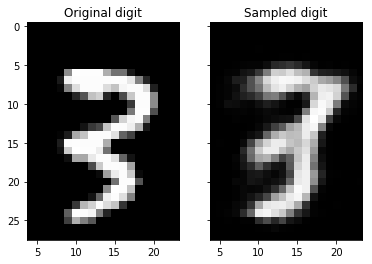

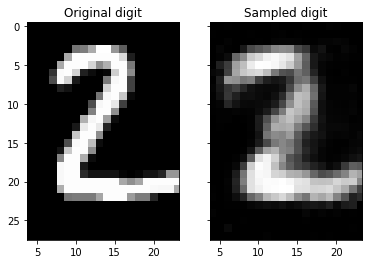

In [26]:
def show_digit(original, fake):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(original.reshape((28,28)),cmap = plt.cm.gray)
    ax1.set_title('Original digit')
    ax2.imshow(fake.reshape((28,28)),cmap = plt.cm.gray)
    ax2.set_title('Sampled digit')
    plt.show()

train_image = mnist_train.images[1] # from train distribution
sample_train = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: train_image.reshape(1,-1).astype(np.float32)})  
show_digit(original=train_image, fake=sample_train)  

test_image = mnist.test.images[1] # from test distribution
sample_test = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: test_image.reshape(1,-1).astype(np.float32)})    
show_digit(original=test_image, fake=sample_test)  

tf.reset_default_graph()